# Multi-variate Rregression Metamodel with DOE based on random sampling
* Input variable space should be constructed using random sampling, not classical factorial DOE
* Linear fit is often inadequate but higher-order polynomial fits often leads to overfitting i.e. learns spurious, flawed relationships between input and output
* R-square fit can often be misleding measure in case of high-dimensional regression
* Metamodel can be constructed by selectively discovering features (or their combination) which matter and shrinking other high-order terms towards zero

#### LASSO: Least Absolute Shrinkage and Selection Operator
$$ {\displaystyle \min _{\beta _{0},\beta }\left\{{\frac {1}{N}}\sum _{i=1}^{N}(y_{i}-\beta _{0}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}|\beta _{j}|\leq t.} $$

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline
plt.style.use('seaborn')

### Generate random (equivalent to Latin Hypercube sampling done in Optislang) feature vectors

In [2]:
np.random.seed(1)
X=np.array(10*np.random.randn(37,5))

In [3]:
df=pd.DataFrame(X,columns=['Feature'+str(l) for l in range(1,6)])

In [4]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5
0,16.243454,-6.117564,-5.281718,-10.729686,8.654076
1,-23.015387,17.448118,-7.612069,3.190391,-2.493704
2,14.621079,-20.601407,-3.224172,-3.840544,11.337694
3,-10.998913,-1.724282,-8.778584,0.422137,5.828152
4,-11.006192,11.447237,9.015907,5.024943,9.008559


### Plot the random distributions of input features

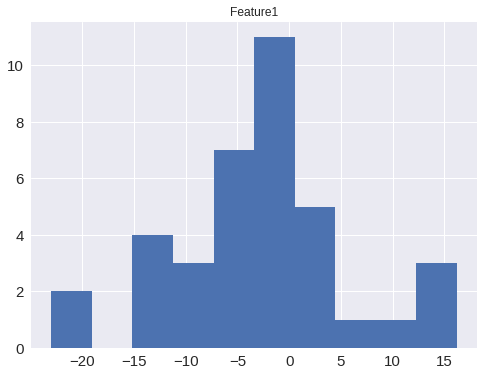

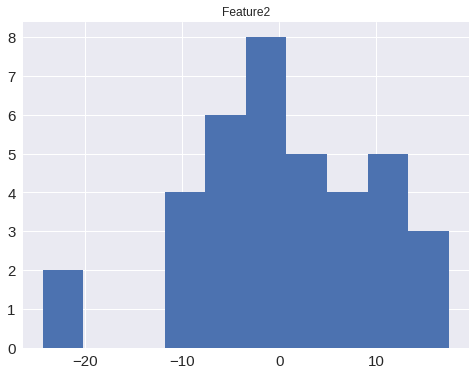

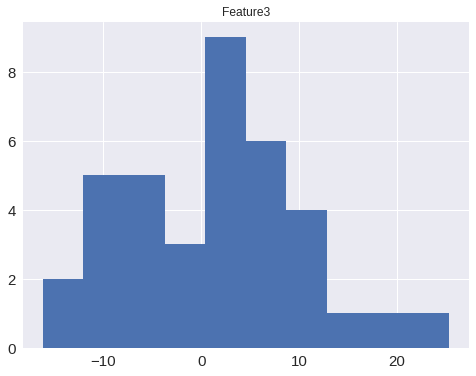

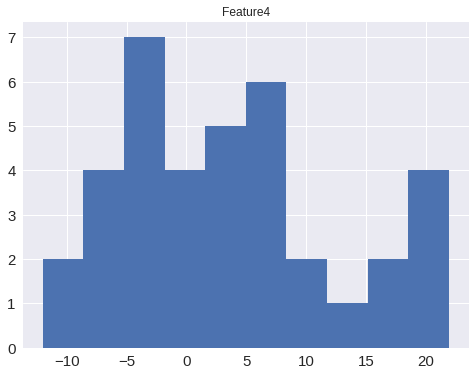

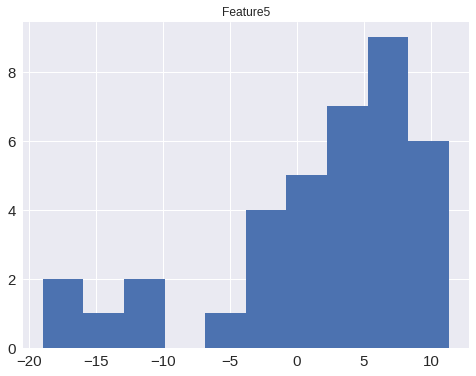

In [5]:
for i in df.columns:
    df.hist(i,bins=10,xlabelsize=15,ylabelsize=15,figsize=(8,6))

### Generate the output variable by analytic function + Gaussian noise (our goal will be to *'learn'* this function)

#### Let's construst the ground  truth  or  originating  function  as  follows: 
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x)\ :\ \psi(x) = {\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}$$

In [6]:
df['y']=5*df['Feature1']**2+13*df['Feature2']+0.1*df['Feature3']**2*df['Feature1'] \
+2*df['Feature4']*df['Feature5']+0.1*df['Feature5']**3+0.8*df['Feature1']*df['Feature4']*df['Feature5'] \
+30*np.random.normal(loc=5,scale=2)

In [7]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,y
0,16.243454,-6.117564,-5.281718,-10.729686,8.654076,70.458939
1,-23.015387,17.448118,-7.612069,3.190391,-2.493704,2983.988371
2,14.621079,-20.601407,-3.224172,-3.840544,11.337694,478.556022
3,-10.998913,-1.724282,-8.778584,0.422137,5.828152,613.730414
4,-11.006192,11.447237,9.015907,5.024943,9.008559,543.053028


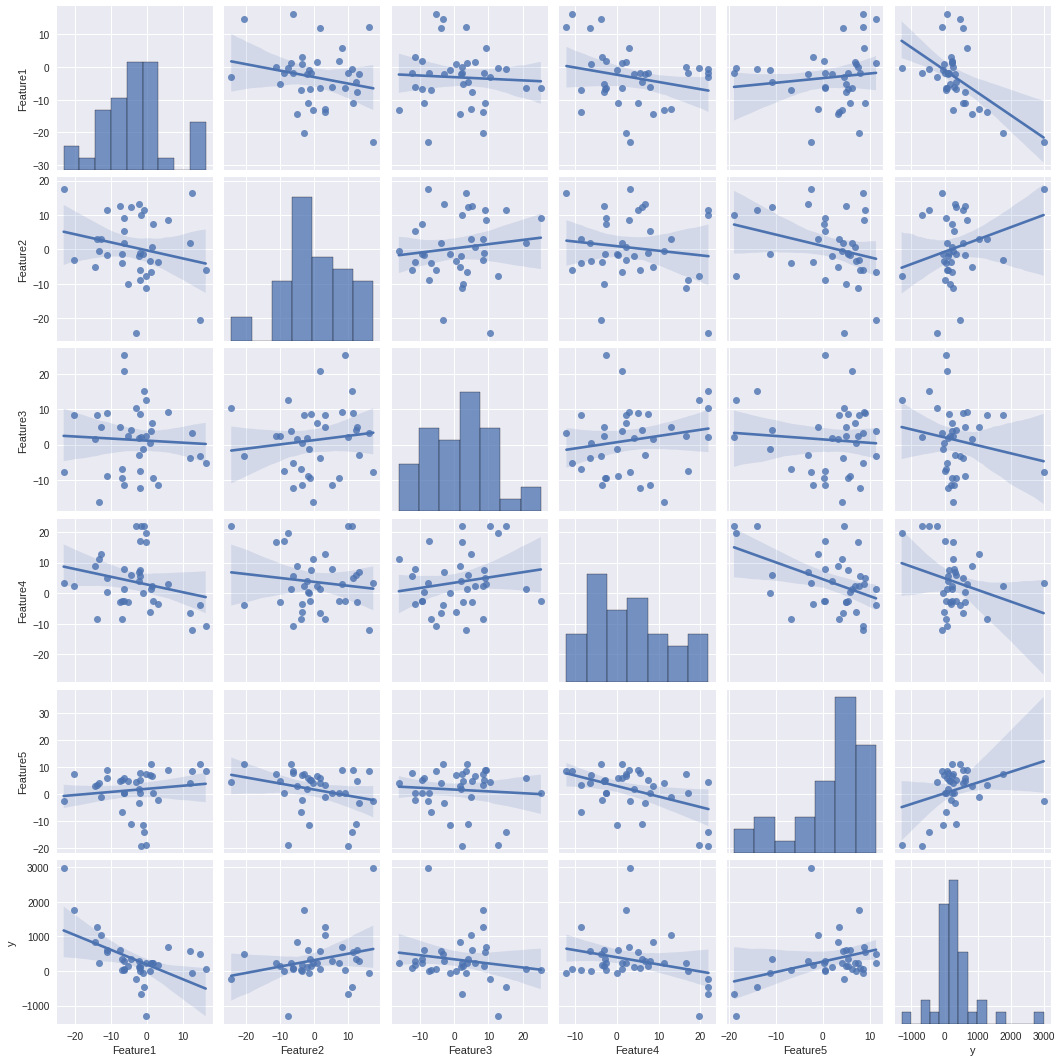

In [8]:
sns.pairplot(df, kind="reg")

### Plot single-variable scatterplots

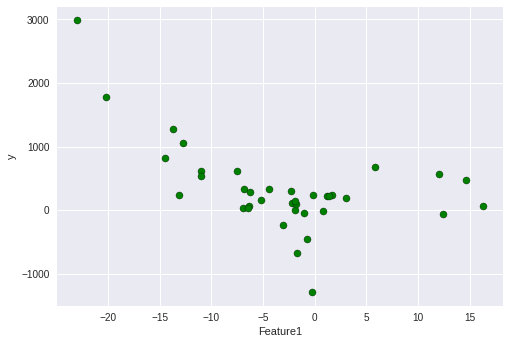

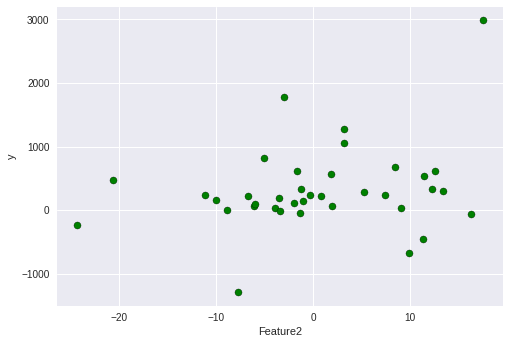

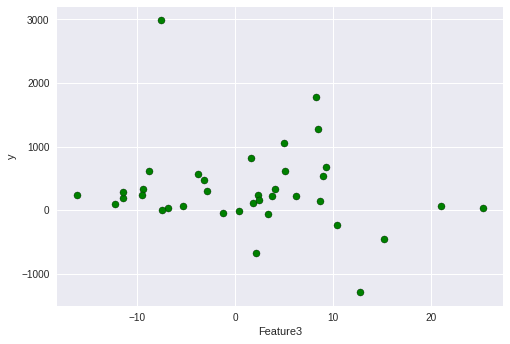

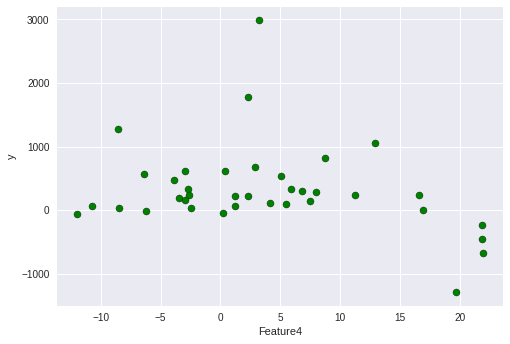

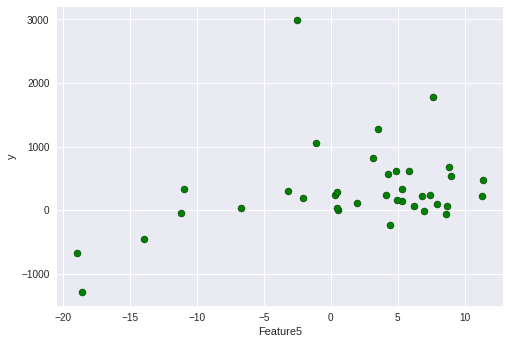

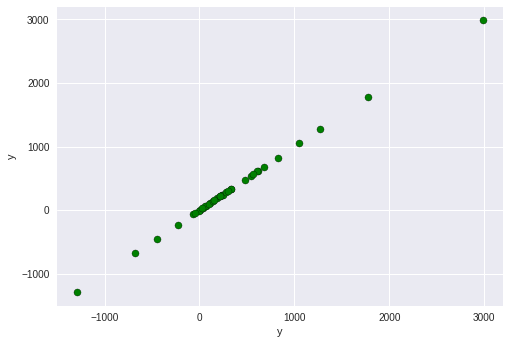

In [9]:
for i in df.columns:
    df.plot.scatter(i,'y', edgecolors=(0,0,0),s=50,c='g',grid=True)

### Standard linear regression

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
linear_model = LinearRegression(normalize=True)

In [12]:
X_linear=df.drop('y',axis=1)
y_linear=df['y']
# X_linear.head()

In [13]:
linear_model.fit(X_linear,y_linear)

/home/mpheng/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [14]:
y_pred_linear = linear_model.predict(X_linear)

### R-square of simple linear fit is very bad, coefficients have no meaning i.e. we did not 'learn' the function

In [15]:
RMSE_linear = np.sqrt(np.sum(np.square(y_pred_linear-y_linear)))

In [16]:
print("Root-mean-square error of linear model:",RMSE_linear)

Root-mean-square error of linear model: 2609.490439338056


In [17]:
coeff_linear = pd.DataFrame(linear_model.coef_,index=df.drop('y',axis=1).columns, columns=['Linear model coefficients'])
coeff_linear

,Linear model coefficients
Feature1,-46.933126
Feature2,16.427210
Feature3,-11.624095
Feature4,-13.719111
Feature5,33.559611


In [18]:
print ("R2 value of linear model:",linear_model.score(X_linear,y_linear))

R2 value of linear model: 0.5952446425066588


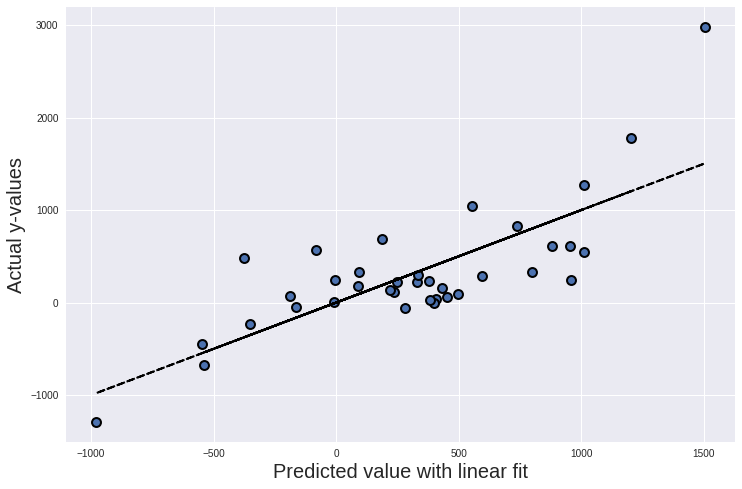

In [19]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred_linear,y_linear,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred_linear,y_pred_linear, 'k--', lw=2)

### Create polynomial features

In [20]:
from sklearn.preprocessing import PolynomialFeatures

In [21]:
poly = PolynomialFeatures(4,include_bias=False)

In [22]:
X_poly = poly.fit_transform(X)
X_poly_feature_name = poly.get_feature_names_out(['Feature'+str(l) for l in range(1,6)])
print(X_poly_feature_name)
print(len(X_poly_feature_name))

['Feature1' 'Feature2' 'Feature3' 'Feature4' 'Feature5' 'Feature1^2'
 'Feature1 Feature2' 'Feature1 Feature3' 'Feature1 Feature4'
 'Feature1 Feature5' 'Feature2^2' 'Feature2 Feature3' 'Feature2 Feature4'
 'Feature2 Feature5' 'Feature3^2' 'Feature3 Feature4' 'Feature3 Feature5'
 'Feature4^2' 'Feature4 Feature5' 'Feature5^2' 'Feature1^3'
 'Feature1^2 Feature2' 'Feature1^2 Feature3' 'Feature1^2 Feature4'
 'Feature1^2 Feature5' 'Feature1 Feature2^2' 'Feature1 Feature2 Feature3'
 'Feature1 Feature2 Feature4' 'Feature1 Feature2 Feature5'
 'Feature1 Feature3^2' 'Feature1 Feature3 Feature4'
 'Feature1 Feature3 Feature5' 'Feature1 Feature4^2'
 'Feature1 Feature4 Feature5' 'Feature1 Feature5^2' 'Feature2^3'
 'Feature2^2 Feature3' 'Feature2^2 Feature4' 'Feature2^2 Feature5'
 'Feature2 Feature3^2' 'Feature2 Feature3 Feature4'
 'Feature2 Feature3 Feature5' 'Feature2 Feature4^2'
 'Feature2 Feature4 Feature5' 'Feature2 Feature5^2' 'Feature3^3'
 'Feature3^2 Feature4' 'Feature3^2 Feature5' 'Feature3 Fe

In [23]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^2 Feature5^2,Feature3 Feature4^3,Feature3 Feature4^2 Feature5,Feature3 Feature4 Feature5^2,Feature3 Feature5^3,Feature4^4,Feature4^3 Feature5,Feature4^2 Feature5^2,Feature4 Feature5^3,Feature5^4
0,16.243454,-6.117564,-5.281718,-10.729686,8.654076,263.849786,-99.370369,-85.793334,-174.287161,140.572087,...,2089.256587,6524.334747,-5262.231299,4244.276132,-3423.239851,13254.034193,-10690.100412,8622.148182,-6954.232085,5608.966915
1,-23.015387,17.448118,-7.612069,3.190391,-2.493704,529.708037,-401.575179,175.194714,-73.428083,57.393557,...,360.325628,-247.192014,193.212575,-151.020652,118.042200,103.603786,-80.979777,63.296184,-49.474166,38.670469
2,14.621079,-20.601407,-3.224172,-3.840544,11.337694,213.775962,-301.214808,-47.140875,-56.152892,165.769330,...,1336.244437,182.640164,-539.173257,1591.696995,-4698.859401,217.555855,-642.248101,1895.984937,-5597.149880,16523.383789
3,-10.998913,-1.724282,-8.778584,0.422137,5.828152,120.976080,18.965228,96.554881,-4.643053,-64.103336,...,2617.644807,-0.660368,-9.117235,-125.875190,-1737.869327,0.031755,0.438422,6.052984,83.569257,1153.781364
4,-11.006192,11.447237,9.015907,5.024943,9.008559,121.136257,-125.990487,-99.230804,-55.305491,-99.149933,...,6596.743052,1143.939228,2050.818049,3676.641699,6591.366890,637.565331,1143.006950,2049.146689,3673.645339,6585.995110


In [24]:
df_poly['y']=df['y']
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3 Feature4^3,Feature3 Feature4^2 Feature5,Feature3 Feature4 Feature5^2,Feature3 Feature5^3,Feature4^4,Feature4^3 Feature5,Feature4^2 Feature5^2,Feature4 Feature5^3,Feature5^4,y
0,16.243454,-6.117564,-5.281718,-10.729686,8.654076,263.849786,-99.370369,-85.793334,-174.287161,140.572087,...,6524.334747,-5262.231299,4244.276132,-3423.239851,13254.034193,-10690.100412,8622.148182,-6954.232085,5608.966915,70.458939
1,-23.015387,17.448118,-7.612069,3.190391,-2.493704,529.708037,-401.575179,175.194714,-73.428083,57.393557,...,-247.192014,193.212575,-151.020652,118.042200,103.603786,-80.979777,63.296184,-49.474166,38.670469,2983.988371
2,14.621079,-20.601407,-3.224172,-3.840544,11.337694,213.775962,-301.214808,-47.140875,-56.152892,165.769330,...,182.640164,-539.173257,1591.696995,-4698.859401,217.555855,-642.248101,1895.984937,-5597.149880,16523.383789,478.556022
3,-10.998913,-1.724282,-8.778584,0.422137,5.828152,120.976080,18.965228,96.554881,-4.643053,-64.103336,...,-0.660368,-9.117235,-125.875190,-1737.869327,0.031755,0.438422,6.052984,83.569257,1153.781364,613.730414
4,-11.006192,11.447237,9.015907,5.024943,9.008559,121.136257,-125.990487,-99.230804,-55.305491,-99.149933,...,1143.939228,2050.818049,3676.641699,6591.366890,637.565331,1143.006950,2049.146689,3673.645339,6585.995110,543.053028


In [25]:
X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

### Polynomial model without regularization and cross-validation

In [26]:
poly = LinearRegression(normalize=True)

In [27]:
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 6.536576097995283e-12


/home/mpheng/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [28]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

,Coefficients polynomial model
Feature1,2.576201
Feature2,9.766111
Feature3,-2.439437
Feature4,4.528293
Feature5,5.787744
...,...
Feature4^4,-0.000173
Feature4^3 Feature5,0.000544
Feature4^2 Feature5^2,-0.000852
Feature4 Feature5^3,0.001046


#### R-square value of the simple polynomial model is perfect but the model is flawed as shown above i.e. it learned wrong coefficients and overfitted the to the data

In [29]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

R2 value of simple polynomial model: 1.0


### Metamodel (Optislang style :) - polynomial model with cross-validation and LASSO regularization
** This is an advanced machine learning method which prevents over-fitting by penalizing high-valued coefficients i.e. keep them bounded **

In [30]:
from sklearn.linear_model import LassoCV

In [31]:
model1 = LassoCV(cv=10,verbose=0,normalize=True,eps=0.001,n_alphas=100, tol=0.0001,max_iter=5000)

In [32]:
model1.fit(X_train,y_train)

/home/mpheng/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoCV(cv=10, max_iter=5000, normalize=True, verbose=0)

In [33]:
y_pred1 = np.array(model1.predict(X_train))

In [34]:
RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print("Root-mean-square error of Metamodel:",RMSE_1)

Root-mean-square error of Metamodel: 11.94880731840907


In [35]:
coeff1 = pd.DataFrame(model1.coef_,index=df_poly.drop('y',axis=1).columns, columns=['Coefficients Metamodel'])
coeff1

,Coefficients Metamodel
Feature1,-0.000000
Feature2,12.854626
Feature3,-0.000000
Feature4,-0.000000
Feature5,0.000000
...,...
Feature4^4,-0.000000
Feature4^3 Feature5,0.000000
Feature4^2 Feature5^2,-0.000015
Feature4 Feature5^3,0.000022


In [36]:
model1.score(X_train,y_train)

0.9999915134670501

In [37]:
model1.alpha_

0.08875712307457442

#### Recall that the ground  truth  or  originating  function  is  as  follows: 
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x) $$

### Printing only the non-zero coefficients of the *metamodel*

In [38]:
coeff1[coeff1['Coefficients Metamodel']!=0]

,Coefficients Metamodel
Feature2,12.854626
Feature1^2,4.961980
Feature3^2,-0.006173
Feature4 Feature5,1.957457
Feature5^2,-0.003592
Feature1^3,-0.000957
Feature1 Feature3^2,0.097120
Feature1 Feature4 Feature5,0.792635
Feature5^3,0.100180
Feature1^4,0.000006


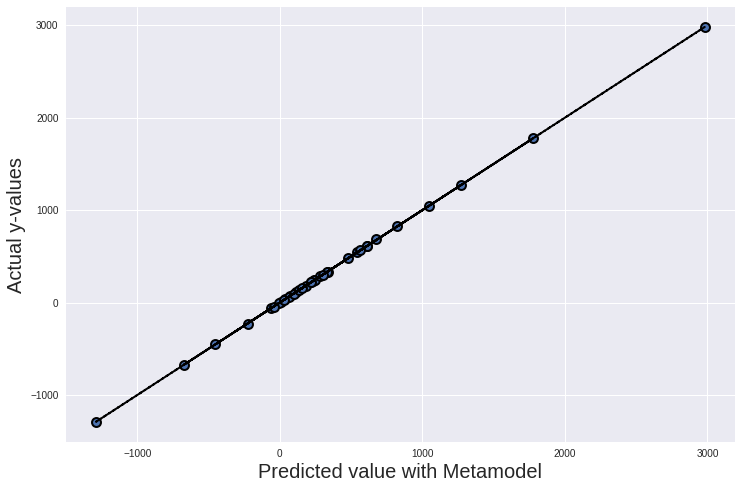

In [39]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred1,y_pred1, 'k--', lw=2)

(-2.0982032168014513,
 1.201796783198549,
 -97208.75551417295,
 2041586.0158260514)

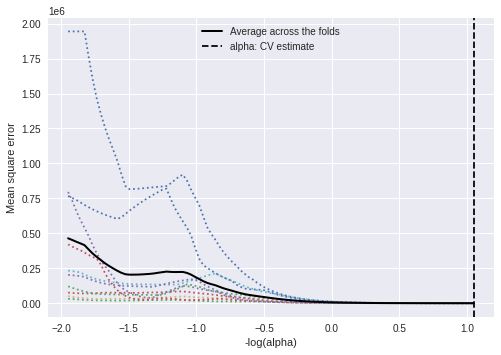

In [40]:
# Display results
m_log_alphas = -np.log10(model1.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model1.mse_path_, ':')
plt.plot(m_log_alphas, model1.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model1.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')